<a href="https://colab.research.google.com/github/MathiasSchindlerCPH/BSE-T2-CML2-repo/blob/main/InClass-1-submit/Mathias_Schindler_NearestNeighbors_InClass1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "../../Data/bgsedsc_0.jpg">

# Project: (K-) Nearest Neighbors


## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient condition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test_death.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_death_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different algorithms for neighbor search and for distance, and justify final selection. Try also different weights to cope with class imbalance and also to balance neighbor proximity. Try to assess somehow confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model. Try to improve it using methods to tackle class imbalance.
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Test the performance on the test file and report accuracy, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

Feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN_CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 20%
+ Data preparation - 35%
+ Nearest neighbor method(s) have been used - 15%
+ Probability of death for each test patient is computed - 10%
+ Accuracy of predictions for test patients is calculated (kaggle) - 10%
+ Hyperparameter optimization - 5%
+ Class imbalance management - 5%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

## New section

In [ ]:
# Mount G Drive
from google.colab import drive
drive.mount('/content/drive')

# Set path
import os
os.chdir('/content/drive/My Drive/--T2-CML2_materials-copy/InClass-submissions/InClass1-KNN')

Mounted at /content/drive


In [ ]:
!ls

extra_data				  mimic_test_death.csv
mimic_kaggle_death_sample_submission.csv  mimic_train.csv
MIMIC_metadata_diagnose.csv		  test_predictions_submit-2.csv
mimic_patient_metadata.xlsx		  test_predictions_submit.csv


In [ ]:
import pandas as pd
# Training dataset
X_train=pd.read_csv('mimic_train.csv', index_col= 1)
X_train.head()

,HOSPITAL_EXPIRE_FLAG,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55440,0,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,F,2108-07-16 00:00:00,2180-03-09 00:00:00,2178-02-06 10:35:00,2178-02-13 18:30:00,NaN,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
76908,0,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,F,2087-01-16 00:00:00,NaN,2129-02-12 22:34:00,2129-02-13 16:20:00,NaN,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
95798,0,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,88.0,72.888889,13.0,21.0,15.900000,36.444444,36.888889,36.666667,100.0,100.0,100.000000,132.0,346.0,217.636364,F,2057-09-17 00:00:00,NaN,2125-11-17 23:04:00,2125-12-05 17:55:00,NaN,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
40708,0,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,94.0,62.783784,12.0,35.0,26.771429,36.333333,39.500000,37.833333,78.0,100.0,95.085714,108.0,139.0,125.000000,F,2056-02-27 00:00:00,2132-03-01 00:00:00,2131-01-26 08:00:00,2131-02-05 16:23:00,NaN,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
28424,0,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,137.0,113.000000,F,2066-12-19 00:00:00,2147-01-18 00:00:00,2146-05-04 02:02:00,2146-05-20 18:40:00,NaN,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [ ]:
# Test dataset (to produce predictions)
data_test=pd.read_csv('mimic_test_death.csv', index_col= 0)
X_test=pd.read_csv('mimic_test_death.csv', index_col= 0)
X_test.sort_values('icustay_id').head()

,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,84.0,59.911765,60.0,109.0,83.861111,18.0,34.0,26.976190,36.444444,37.666667,37.005556,89.0,100.0,95.605263,94.0,108.0,101.000000,F,2104-05-13 00:00:00,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,125.0,125.000000,F,2053-08-08 00:00:00,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,80.0,43.363636,49.0,88.0,59.848485,11.0,27.0,18.861111,36.444444,37.388889,36.816667,88.0,100.0,96.027778,125.0,297.0,199.875000,M,2054-03-21 00:00:00,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,64.0,53.707317,14.0,83.0,68.826667,9.0,22.0,17.291667,NaN,NaN,NaN,87.0,100.0,96.837209,95.0,196.0,127.368421,M,2104-02-12 00:00:00,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,91.0,64.281250,57.0,97.0,75.343750,9.0,28.0,21.029412,35.555556,38.888889,37.489899,92.0,100.0,95.617647,81.0,134.0,117.833333,M,2072-04-09 00:00:00,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


In [ ]:
# Sample output prediction file
#pred_sample=pd.read_csv('../../Data/mimic_kaggle_death_sample_submission.csv')
#pred_sample.sort_values('icustay_id').head()

## Data Exploration

### Removing missing data

Investigating the distribution of NaNs. First try: Delete rows if any feature is zero.

In [ ]:
# Your code here
print(X_train.isna().sum())
print("\n X dimensions:")
print(X_train.shape)

HOSPITAL_EXPIRE_FLAG        0
hadm_id                     0
icustay_id                  0
HeartRate_Min            2187
HeartRate_Max            2187
HeartRate_Mean           2187
SysBP_Min                2208
SysBP_Max                2208
SysBP_Mean               2208
DiasBP_Min               2209
DiasBP_Max               2209
DiasBP_Mean              2209
MeanBP_Min               2186
MeanBP_Max               2186
MeanBP_Mean              2186
RespRate_Min             2189
RespRate_Max             2189
RespRate_Mean            2189
TempC_Min                2497
TempC_Max                2497
TempC_Mean               2497
SpO2_Min                 2203
SpO2_Max                 2203
SpO2_Mean                2203
Glucose_Min               253
Glucose_Max               253
Glucose_Mean              253
GENDER                      0
DOB                         0
DOD                     13511
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               18540
Diff      

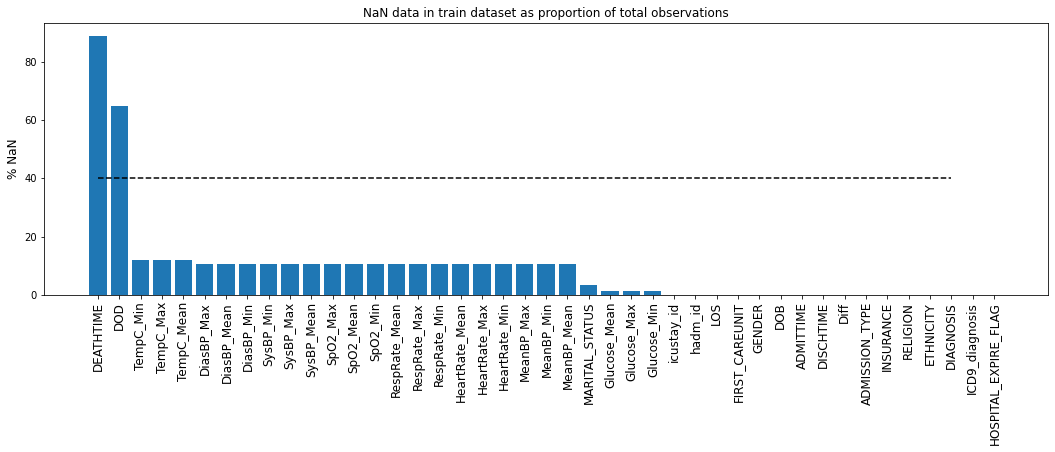

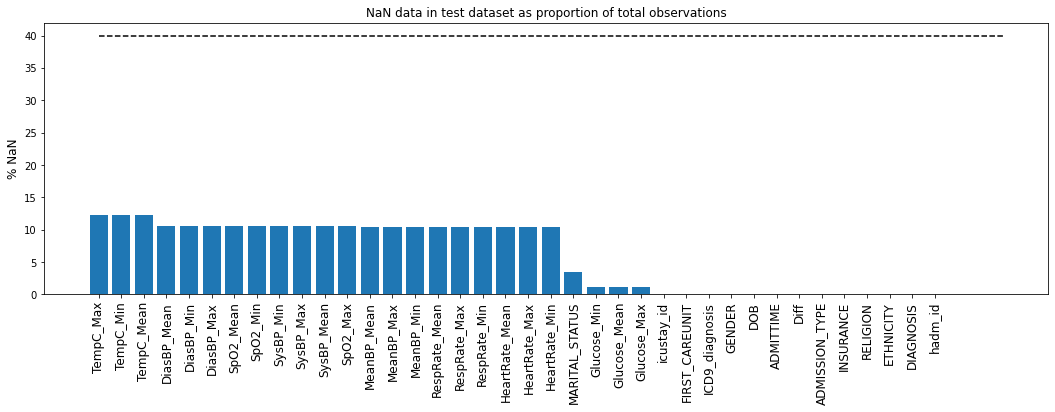

<BarContainer object of 38 artists>

In [ ]:
import matplotlib.pyplot as plt

def make_nan_fig(df, title):
  nan_df = df.isnull().sum()/len(df)*100
  nan_df = nan_df.sort_values(ascending = False)

  nan_df_fig = plt.bar(nan_df.index, nan_df.values)
  plt.xticks(rotation='vertical', fontsize = 12)
  plt.ylabel('% NaN', fontsize = 12)
  plt.hlines(y=40, xmin= 0, xmax = 40, linestyle = 'dashed')
  plt.title('NaN data in ' + title + ' dataset as proportion of total observations')
  fig = plt.gcf()
  fig.set_size_inches(18, 5)
  plt.show()
  return nan_df_fig

make_nan_fig(X_train, "train")
make_nan_fig(X_test, "test")

Imputing NaNs with mean in order to preserve same number of rows that is necessary for exporting predictions and Kaggle.

In [ ]:
X_train_nona = X_train.fillna(X_train.mean())
X_test_nona = X_test.fillna(X_train.mean())

In [ ]:
print(X_train_nona.isna().sum()); print(X_test_nona.isna().sum())

HOSPITAL_EXPIRE_FLAG        0
hadm_id                     0
icustay_id                  0
HeartRate_Min               0
HeartRate_Max               0
HeartRate_Mean              0
SysBP_Min                   0
SysBP_Max                   0
SysBP_Mean                  0
DiasBP_Min                  0
DiasBP_Max                  0
DiasBP_Mean                 0
MeanBP_Min                  0
MeanBP_Max                  0
MeanBP_Mean                 0
RespRate_Min                0
RespRate_Max                0
RespRate_Mean               0
TempC_Min                   0
TempC_Max                   0
TempC_Mean                  0
SpO2_Min                    0
SpO2_Max                    0
SpO2_Mean                   0
Glucose_Min                 0
Glucose_Max                 0
Glucose_Mean                0
GENDER                      0
DOB                         0
DOD                     13511
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               18540
Diff      

In [ ]:
#  Compare columns
print(X_train_nona.columns.difference(X_test_nona.columns))

# Delete thos from train
X_train_nona = X_train_nona.drop(['DEATHTIME', 'DISCHTIME', 'DOD', 'LOS'], axis = 1)
X_train_nona

Index(['DEATHTIME', 'DISCHTIME', 'DOD', 'HOSPITAL_EXPIRE_FLAG', 'LOS'], dtype='object')


,HOSPITAL_EXPIRE_FLAG,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55440,0,195768,228357,89.000000,145.000000,121.043478,74.000000,127.00000,106.586957,42.000000,90.000000,61.173913,59.000000,94.000000,74.543478,15.000000,30.00000,22.347826,35.111111,36.944444,36.080247,90.000000,99.000000,95.739130,111.0,230.0,160.777778,F,2108-07-16 00:00:00,2178-02-06 10:35:00,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU
76908,0,126136,221004,63.000000,110.000000,79.117647,89.000000,121.00000,106.733333,49.000000,74.000000,64.733333,58.000000,84.000000,74.800000,13.000000,21.00000,16.058824,36.333333,36.611111,36.472222,98.000000,100.000000,99.058824,103.0,103.0,103.000000,F,2087-01-16 00:00:00,2129-02-12 22:34:00,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU
95798,0,136645,296315,81.000000,98.000000,91.689655,88.000000,138.00000,112.785714,45.000000,67.000000,56.821429,64.000000,88.000000,72.888889,13.000000,21.00000,15.900000,36.444444,36.888889,36.666667,100.000000,100.000000,100.000000,132.0,346.0,217.636364,F,2057-09-17 00:00:00,2125-11-17 23:04:00,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU
40708,0,102505,245557,76.000000,128.000000,98.857143,84.000000,135.00000,106.972973,30.000000,89.000000,41.864865,48.000000,94.000000,62.783784,12.000000,35.00000,26.771429,36.333333,39.500000,37.833333,78.000000,100.000000,95.085714,108.0,139.0,125.000000,F,2056-02-27 00:00:00,2131-01-26 08:00:00,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU
28424,0,127337,225281,69.705904,105.239801,85.180250,91.110564,150.72592,119.145423,44.327854,88.360784,62.511614,56.293064,107.074282,77.609535,11.919207,27.78022,18.985855,36.051208,37.428781,36.751717,91.007494,99.555883,96.866685,97.0,137.0,113.000000,F,2066-12-19 00:00:00,2146-05-04 02:02:00,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28043,0,135417,244530,65.000000,92.000000,78.500000,60.000000,160.00000,110.976190,34.000000,94.000000,56.595238,41.000000,102.000000,69.285714,10.000000,23.00000,15.420000,35.555556,36.611111,36.155556,97.000000,100.000000,99.833333,68.0,139.0,103.571429,M,2088-12-15 00:00:00,2176-06-17 06:36:00,-60714.92678,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,ALTERED MENTAL STATUS,3229,MICU
87605,0,191007,216116,74.000000,112.000000,89.156250,100.000000,150.00000,123.272727,58.000000,83.000000,67.818182,74.000000,99.000000,82.363636,9.000000,24.00000,14.781250,37.055556,37.777778,37.476190,95.000000,100.000000,97.531250,184.0,377.0,245.400000,M,2071-11-18 00:00:00,2137-09-27 23:14:00,-46217.77777,EMERGENCY,Private,NOT SPECIFIED,MARRIED,BLACK/HAITIAN,NEW BRAIN MASS,1918,SICU
47492,0,152608,274507,58.000000,97.000000,76.933333,94.000000,131.00000,112.037037,55.000000,83.000000,67.370370,66.000000,95.000000,78.500000,14.000000,27.00000,18.166667,36.055556,37.277778,37.007937,97.000000,100.000000,99.200000,51.0,460.0,190.000000,F,2055-11-27 00:00:00,2118-10-18 17:54:00,-39830.10848,EMERGENCY,Private,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,HYPOGLYCEMIA,24980,MICU


In [ ]:
# Drop date variables (too complicated to work with for inclass)
datevar = ["DOB", "ADMITTIME"]
X_train_nona = X_train_nona.drop(datevar, axis = 1)
X_test_nona = X_test_nona.drop(datevar, axis = 1)

In [ ]:
X_train_nona.dtypes

HOSPITAL_EXPIRE_FLAG      int64
hadm_id                   int64
icustay_id                int64
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                   object
Diff                    float64
ADMISSION_TYPE           object
INSURANCE                object
RELIGION

In [ ]:
#Check data types
#X_train_num.dtypes

## EDA

In [ ]:
%%script false
import seaborn as sns
# plot the heatmap
colormap = plt.cm.RdBu

sns.heatmap(X_train_nona.corr(), 
            linewidths=0.1, 
            square=False, 
            cmap=colormap, 
            linecolor='white', 
            annot=True)
fig = plt.gcf()
fig.set_size_inches(25, 16)

In [ ]:
%%script false
X_train_nona.hist()
fig = plt.gcf()
fig.set_size_inches(18, 15)
plt.show()

## Data Preprocessing

For inclass I will only use numerical data as I suspect runtime will be too long with one-hot encoding due to many categorical features and hence high dimensional data.

In [ ]:
# Set target 
y_train = X_train_nona['HOSPITAL_EXPIRE_FLAG']

# Set features
X_train_nona = X_train_nona.drop('HOSPITAL_EXPIRE_FLAG', axis = 1)

In [ ]:
# Numerical Data
cat_feat_lst = ["GENDER", "ADMISSION_TYPE", "INSURANCE", "RELIGION", "MARITAL_STATUS", "ETHNICITY", "DIAGNOSIS", "ICD9_diagnosis", "FIRST_CAREUNIT"]

X_train_num = X_train_nona.drop(cat_feat_lst, axis = 1)
X_test_num = X_test_nona.drop(cat_feat_lst, axis = 1)

In [ ]:
# Categorical Data
X_train_cat = X_train_nona[cat_feat_lst]
X_test_cat = X_test_nona[cat_feat_lst]

In [ ]:
from sklearn.preprocessing import StandardScaler

# Instantiate scaler
scaler = StandardScaler()

# Fit to data
scaler.fit(X_train_num)

# Transform data
X_train_scl = scaler.transform(X_train_num)
X_test_scl = scaler.transform(X_test_num)

# Format data
X_train_scl = pd.DataFrame(X_train_scl, columns = X_train_num.columns, index = X_train_num.index)
X_test_scl = pd.DataFrame(X_test_scl, columns = X_test_num.columns, index = X_test_num.index)

## Estimating

In [ ]:
# Run a model
from sklearn.neighbors import KNeighborsClassifier

# Instantiate
knn_multi = KNeighborsClassifier(n_neighbors = 20, algorithm='brute')

# Fit 
knn_multi.fit(X_train_scl, y_train)

# Predict
y_hat = knn_multi.predict(X_train_scl)
p_hat = knn_multi.predict_proba(X_train_scl)

# Class Imbalance

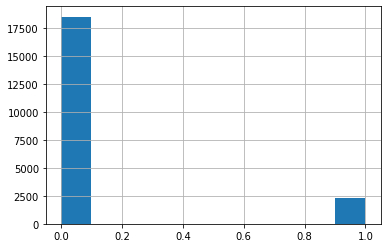

In [ ]:
y_train.hist()

In [ ]:
# RandomOverSampler
from imblearn.over_sampling import RandomOverSampler 
ros = RandomOverSampler(sampling_strategy = 0.5)

X_ros, y_ros = ros.fit_resample(X_train_scl, y_train)

In [ ]:
y_ros.value_counts()

0    18540
1     9270
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [ ]:
# Estimate
# Instantiate
knn_imb = KNeighborsClassifier(n_neighbors = 20, algorithm='brute')

# Fit 
knn_imb.fit(X_ros, y_ros)

# Predict
y_hat = knn_imb.predict(X_ros)
p_hat = knn_imb.predict_proba(X_ros)[:,1]
print(y_hat)

[0 0 0 ... 1 1 0]


### Kaggle Predictions Submissions

Once you have produced testset predictions you can submit these to <i> kaggle </i> in order to see how your model performs. 

The following code provides an example of generating a <i> .csv </i> file to submit to kaggle
1) create a pandas dataframe with two columns, one with the test set "icustay_id"'s and the other with your predicted "HOSPITAL_EXPIRE_FLAG" for that observation

2) use the <i> .to_csv </i> pandas method to create a csv file. The <i> index = False </i> is important to ensure the <i> .csv </i> is in the format kaggle expects 

In [ ]:
#y_hat_test = knn_multi.predict(X_test_scl)

In [ ]:
y_hat_test = knn_imb.predict(X_test_scl)

In [ ]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_hat_test})
test_predictions_submit.to_csv("test_predictions_submit-2.csv", index = False)